In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
df_train = pd.read_csv('SupportingFiles/train.csv')
df_test = pd.read_csv('SupportingFiles/test.csv')

In [3]:
# Take a look at what we are working with
df_train.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  int64 
 1   bin_0   300000 non-null  int64 
 2   bin_1   300000 non-null  int64 
 3   bin_2   300000 non-null  int64 
 4   bin_3   300000 non-null  object
 5   bin_4   300000 non-null  object
 6   nom_0   300000 non-null  object
 7   nom_1   300000 non-null  object
 8   nom_2   300000 non-null  object
 9   nom_3   300000 non-null  object
 10  nom_4   300000 non-null  object
 11  nom_5   300000 non-null  object
 12  nom_6   300000 non-null  object
 13  nom_7   300000 non-null  object
 14  nom_8   300000 non-null  object
 15  nom_9   300000 non-null  object
 16  ord_0   300000 non-null  int64 
 17  ord_1   300000 non-null  object
 18  ord_2   300000 non-null  object
 19  ord_3   300000 non-null  object
 20  ord_4   300000 non-null  object
 21  ord_5   300000 non-null  object
 

<AxesSubplot:xlabel='target', ylabel='count'>

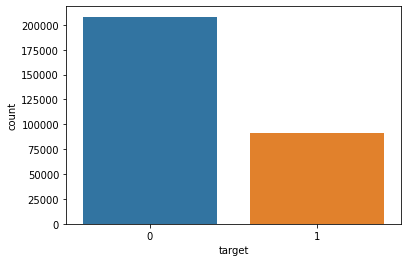

In [5]:
# Count plot to see how the target classification is distributed
sns.countplot(x='target',data=df_train)

Although it's not evenly distributed, the target is binary making it easy to apply our method. 

# Build Models Using Get Dummies on Every Column

In [6]:
# Combine test and train in order to ensure they have the same columns from get_dummies
# Note: This is a short coming of get_dummies, this method is a popular one but can cause leakage
df_train['IsTrain'] = 1
df_test['IsTrain'] = 0
df_full = pd.concat([df_train,df_test])

# Save Test IDs for later
test_ids = df_test['id']

In [7]:
# Drop any column with more than 50 unique items it will be too hard to use dummy variables on them
for col in  df_full.columns:
    if len(df_full[col].unique()) > 300:
        df_full.drop(col, axis =1, inplace = True)
        print (col)
        
# Get Dummies on the rest of the columns left over
df_full = pd.get_dummies(df_full, drop_first = True)

id
nom_6
nom_7
nom_8
nom_9


In [8]:
len(df_full.columns)

490

The amount of columns created from get dummies is extremley high but these extreme cases are what we are trying to test.

In [9]:
# Split the data back out
df_train = df_full[df_full['IsTrain']==1]
df_train.drop('IsTrain', axis = 1,inplace = True)
df_test = df_full[df_full['IsTrain']==0]
df_test.drop('IsTrain', axis = 1, inplace = True)
df_test.drop('target',axis = 1, inplace=True)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
# Split out independent varialbles
y = df_train['target']
X = df_train.drop('target', axis = 1)
#X.drop('id',inplace=True,axis = 1)

# Save id for the test set and drop it for testing later
#df_test.drop('id',axis = 1, inplace = True)

## Build Some Basic Models

In [11]:
# Split into Test and Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3)

In [12]:
# Train on Logistic Regression & Random Forest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier()

# Fit to training data
model_lr.fit(X_train,y_train)
model_rf.fit(X_train,y_train)

# Apply to test
pred_lr = model_lr.predict_proba(X_test)[:, 1]
pred_rf = model_rf.predict_proba(X_test)[:, 1]

# Get AUC Score
from sklearn.metrics import roc_auc_score
print(f"Logistic Regression AUC: {roc_auc_score(y_test, pred_lr)} Random Forest: {roc_auc_score(y_test, pred_rf)}")

Logistic Regression AUC: 0.7733943482441041 Random Forest: 0.7262865150502253


## Build More Complex ML Methods

In [13]:
# XGBoost
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train,y_train)
pred_xg = model_xg.predict_proba(X_test)[:, 1]

print(f"XGBoost AUC: {roc_auc_score(y_test, pred_xg)}")

XGBoost AUC: 0.7575400325700306


In [14]:
# Artificial Neural Network (TensofFlow)

# Build Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

model = Sequential()

model.add(Dense(units=490,activation='relu'))
model.add(Dropout(0.5)) # Use Drop out so it can be comapred later even though this probably wont effect our model
model.add(Dense(units=245,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=50,activation='relu'))
model.add(Dropout(0.5))
# BINARY CLASSIFICATION uses sigmoid
model.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')


In [15]:
# Use early stop to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.fit(x=X_train.values, 
          y=y_train.values, 
          epochs=50, 
          validation_data=(X_test.values, y_test.values), 
          verbose=1,
          batch_size=256,
          callbacks=[early_stop]
          )

Epoch 1/50
821/821 [==============================] - 8s 10ms/step - loss: 0.5532 - val_loss: 0.5192
Epoch 2/50
821/821 [==============================] - 7s 9ms/step - loss: 0.5251 - val_loss: 0.5158
Epoch 3/50
821/821 [==============================] - 7s 8ms/step - loss: 0.5181 - val_loss: 0.5146
Epoch 4/50
821/821 [==============================] - 7s 9ms/step - loss: 0.5137 - val_loss: 0.5133
Epoch 5/50
821/821 [==============================] - 7s 9ms/step - loss: 0.5093 - val_loss: 0.5148
Epoch 6/50
821/821 [==============================] - 6s 8ms/step - loss: 0.5049 - val_loss: 0.5164
Epoch 7/50
821/821 [==============================] - 7s 8ms/step - loss: 0.4997 - val_loss: 0.5174
Epoch 8/50
821/821 [==============================] - 6s 8ms/step - loss: 0.4942 - val_loss: 0.5196
Epoch 9/50
821/821 [==============================] - 7s 8ms/step - loss: 0.4867 - val_loss: 0.5227
Epoch 10/50
821/821 [==============================] - 7s 8ms/step - loss: 0.4797 - val_loss: 0.526

In [16]:
predictions = model.predict(X_test)
roc_auc_score(y_test,predictions)

0.7498499818008065

## Fit to Test Data

Fit our best moden (Artificial Neural Networks) to the test data to test data to see if our data was overfit

In [17]:
# Test Base Level
final = model_rf.predict_proba(df_test)[:, 1]

In [18]:
# Print results
submission = pd.DataFrame({'id': test_ids.values, 'target': final.ravel()})
submission.to_csv('Submissions/submission.csv', index=False)

Kaggle Result: 0.72451

# Develop Logic for Replacing Categorical Attributes

Now lets see if the new methodology of replacing categorial fields with ranked numbers improves our score

In [19]:
# Reload the data for a fresh start
df_train = pd.read_csv('SupportingFiles/train.csv')
df_test = pd.read_csv('SupportingFiles/test.csv')

In [20]:
from DSHelper import CatEncoder

In [21]:
CatEncoder.GetOrdinal(df_train,'target',df_test=df_test,normalize=True)

In [22]:
# Check test data for nulls (this would be due to new categories)
nulls= df_test.isnull().sum()
print(nulls[nulls > 0])

nom_8      8
nom_9    144
dtype: int64


In [23]:
# Replace with the mode so that a new category is not created
df_test['nom_8'].fillna(df_test['nom_8'].mode()[0], inplace=True)
df_test['nom_9'].fillna(df_test['nom_9'].mode()[0], inplace=True)

In [24]:
y = df_train['target']
X = df_train.drop('target', axis = 1)
X.drop('id', axis = 1, inplace = True)

# See if Basic Models Improve

In [25]:
# Split into Test and Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3)

In [26]:
# Train on Logistic Regression & Random Forest
model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier()

# Fit to training data
model_lr.fit(X_train,y_train)
model_rf.fit(X_train,y_train)

# Apply to test
pred_lr = model_lr.predict_proba(X_test)[:, 1]
pred_rf = model_rf.predict_proba(X_test)[:, 1]

# Get AUC Score
from sklearn.metrics import roc_auc_score
print(f"Logistic Regression AUC: {roc_auc_score(y_test, pred_lr)} Random Forest: {roc_auc_score(y_test, pred_rf)}")

Logistic Regression AUC: 0.8292738529400155 Random Forest: 0.8086852330796618


Both have sigificant increases and much less time! But we are actually hoping for a better performance with more complex models. So next step will to be to test how it interacts with bag, boosting, and dropout layers.

# Complex ML Models w/ New Categorical Method

In [27]:
# XGBoost
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train,y_train)
pred_xg = model_xg.predict_proba(X_test)[:, 1]

print(f"XGBoost AUC: {roc_auc_score(y_test, pred_xg)}")

XGBoost AUC: 0.8222501687949861


In [28]:
# Artificial Neural Network (TensofFlow)

# Build Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
# Artificial Neural Network (TensofFlow)

# Build Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

model = Sequential()

model.add(Dense(units=490,activation='relu'))
model.add(Dropout(0.5)) # Use Drop out so it can be comapred later even though this probably wont effect our model
model.add(Dense(units=245,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=50,activation='relu'))
model.add(Dropout(0.5))
# BINARY CLASSIFICATION uses sigmoid
model.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.fit(x=X_train.values, 
          y=y_train.values, 
          epochs=100, 
          validation_data=(X_test.values, y_test.values), 
          verbose=1,
          batch_size=256,
          callbacks=[early_stop]
          )

Epoch 1/100
821/821 [==============================] - 6s 8ms/step - loss: 0.5678 - val_loss: 0.4893
Epoch 2/100
821/821 [==============================] - 7s 8ms/step - loss: 0.4972 - val_loss: 0.4678
Epoch 3/100
821/821 [==============================] - 7s 8ms/step - loss: 0.4786 - val_loss: 0.4620
Epoch 4/100
821/821 [==============================] - 7s 8ms/step - loss: 0.4744 - val_loss: 0.4681
Epoch 5/100
821/821 [==============================] - 6s 8ms/step - loss: 0.4716 - val_loss: 0.4586
Epoch 6/100
821/821 [==============================] - 6s 8ms/step - loss: 0.4707 - val_loss: 0.4639
Epoch 7/100
821/821 [==============================] - 6s 8ms/step - loss: 0.4701 - val_loss: 0.4562
Epoch 8/100
821/821 [==============================] - 6s 8ms/step - loss: 0.4697 - val_loss: 0.4702
Epoch 9/100
821/821 [==============================] - 6s 8ms/step - loss: 0.4693 - val_loss: 0.4558
Epoch 10/100
821/821 [==============================] - 6s 8ms/step - loss: 0.4679 - val_lo

<AxesSubplot:>

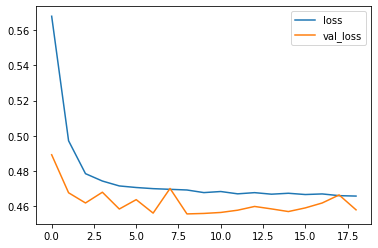

In [30]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [31]:
predictions = model.predict(X_test)
roc_auc_score(y_test,predictions)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



0.8307645128786989

# Export to be Evaluated

In [32]:
test_ids = df_test['id']
df_test.drop('id', inplace= True, axis =1 )

In [33]:
model_lr.fit(X,y)
pred_lr = model_rf.predict_proba(df_test)[:, 1]

In [34]:
model.fit(x=X.values, 
          y=y.values, 
          epochs=40, 
          verbose=1,
          batch_size=256,
          )
model_lr.fit(X,y)
final = model.predict(df_test)
pred_lr = model_rf.predict_proba(df_test)[:, 1]

Epoch 1/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4670
Epoch 2/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4664
Epoch 3/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4669
Epoch 4/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4658
Epoch 5/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4657
Epoch 6/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4660
Epoch 7/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4655
Epoch 8/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4657
Epoch 9/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4652
Epoch 10/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4657
Epoch 11/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4651
Epoch 12/40
1172/1172 [==============================] - 8s 7ms/step - loss: 0.4651
E

In [36]:
# Print results
submission = pd.DataFrame({'id': test_ids.values, 'target': final.ravel()})
submission.to_csv('Submissions/ann_submission.csv', index=False)

submission = pd.DataFrame({'id': test_ids.values, 'target': pred_lr})
submission.to_csv('Submissions/lr_submission.csv', index=False)

ANN Kaggle Result: 0.78768 <br /> Logistic Regression Kaggle Result: 0.76443